## Cálculo de prazos e ciclos

In [2]:
# bibliotecas usadas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

<>:2: SyntaxWarning: invalid escape sequence '\{'
<>:2: SyntaxWarning: invalid escape sequence '\{'
C:\Users\Madu\AppData\Local\Temp\ipykernel_21636\1851803340.py:2: SyntaxWarning: invalid escape sequence '\{'
  caminho_arquivo = 'C:\{estudos}\ADC - Embraer SA\Embraer-SA\Demonstrações_Embraer_Ajustado.xlsm'


✅ Arquivo carregado. Abas: ['Ativo', 'Passivo', 'DRE', 'DFC']

--- Indicadores Calculados (em Dias) ---
      PME (Estocagem)  PMR (Recebimento)  PMP (Pagamento)  Ciclo Operacional  \
2020            295.1               22.4             39.2              317.5   
2021            221.9               18.7             67.8              240.6   
2022            246.5               21.5             79.3              267.9   
2023            214.8               15.2             67.0              230.0   
2024            228.5               21.2             67.4              249.7   

      Ciclo Financeiro  
2020             278.3  
2021             172.9  
2022             188.7  
2023             163.0  
2024             182.4  

✅ Tabela salva em 'Prazos_e_Ciclos_Embraer.xlsx'


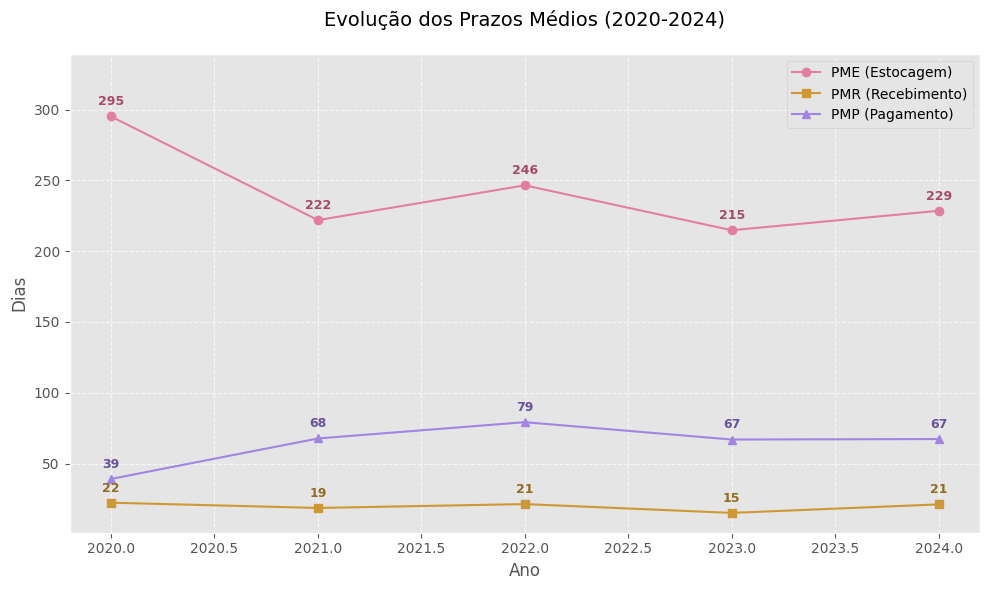

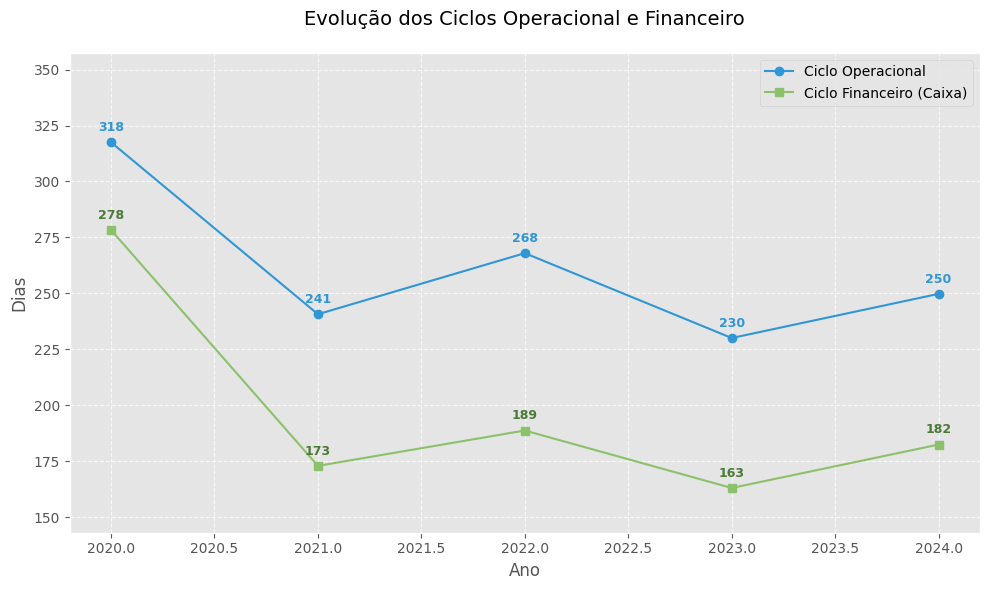

In [ ]:
# --- 1. CARREGAR DADOS BRUTOS ---
caminho_arquivo = 'C:\{estudos}\ADC - Embraer SA\Embraer-SA\Demonstrações_Embraer_Ajustado.xlsm'

try:
    # Carrega as abas necessárias
    xlsx = pd.read_excel(caminho_arquivo, sheet_name=None)
    df_ativo = xlsx['Ativo']
    df_passivo = xlsx['Passivo']
    df_dre = xlsx['DRE']
    print(f"✅ Arquivo carregado. Abas: {list(xlsx.keys())}")
except FileNotFoundError:
    print(f"❌ Arquivo '{caminho_arquivo}' não encontrado. Verifique o nome.")
    # Pare a execução se não tiver o arquivo
    exit()

# --- 2. EXTRAÇÃO DAS CONTAS (Mapeamento) ---
# Função auxiliar para pegar a linha pelo código
def pegar_valor(df, codigo):
    # Tenta encontrar a coluna de código (pode variar entre 'CD_CONTA', 'Código', etc.)
    col_cod = next((c for c in df.columns if 'CD' in c or 'Cod' in c), None)
    if not col_cod: return None
    
    # Filtra e retorna os valores dos anos (colunas numéricas)
    linha = df[df[col_cod].astype(str).str.strip() == str(codigo)]
    if linha.empty: return None
    
    colunas_anos = [c for c in df.columns if str(c).isdigit()]
    return linha[colunas_anos].iloc[0]

# Extraindo as séries temporais necessárias
# CÓDIGOS PADRÃO (Verifique se batem com seu Excel)
receita = pegar_valor(df_dre, '3.01') # Receita Líquida
cmv = pegar_valor(df_dre, '3.02')     # Custos (CMV) - geralmente negativo
estoques = pegar_valor(df_ativo, '1.01.04') # Estoques
clientes = pegar_valor(df_ativo, '1.01.03') # Contas a Receber / Clientes
fornecedores = pegar_valor(df_passivo, '2.01.02') # Fornecedores

ESTOQUE_2019 = 5257749

# Ajuste de sinal do CMV (para positivo)
if cmv is not None: cmv = cmv.abs()

# Verifica se pegou tudo
if any(v is None for v in [receita, cmv, estoques, clientes, fornecedores]):
    print("⚠️ Alguma conta não foi encontrada. Verifique os códigos no Excel.")
else:
# --- 2. CÁLCULO DOS INDICADORES (COM AJUSTE DE COMPRAS) ---
    indicadores = pd.DataFrame(index=receita.index)

    # Cálculo preciso das COMPRAS
    # Cria uma série para o estoque anterior deslocando 1 ano
    estoque_anterior = estoques.shift(1)
    
    # Preenche o primeiro ano (2020) com o valor manual de 2019
    # O .iloc[0] se refere ao primeiro ano da série (2020)
    estoque_anterior.iloc[0] = ESTOQUE_2019
    
    # Fórmula: Compras = CMV + Estoque Final - Estoque Inicial
    compras_reais = cmv + (estoques - estoque_anterior)

    # 3.1 Prazos Médios (Dias)
    indicadores['PME (Estocagem)'] = (estoques / cmv) * 365
    indicadores['PMR (Recebimento)'] = (clientes / receita) * 365
    
    # AGORA USAMOS 'compras_reais' EM VEZ DE 'cmv'
    indicadores['PMP (Pagamento)'] = (fornecedores / compras_reais) * 365

    # 3.2 Ciclos
    indicadores['Ciclo Operacional'] = indicadores['PME (Estocagem)'] + indicadores['PMR (Recebimento)']
    indicadores['Ciclo Financeiro'] = indicadores['Ciclo Operacional'] - indicadores['PMP (Pagamento)']

    print("\n--- Indicadores Calculados (em Dias) ---")
    print(indicadores.round(1))

    # --- 4. EXPORTAÇÃO E VISUALIZAÇÃO GRÁFICA ---
    
    # Salvar em Excel
    indicadores.to_excel("Prazos_e_Ciclos_Embraer.xlsx")
    print("\n✅ Tabela salva em 'Prazos_e_Ciclos_Embraer.xlsx'")

    # Plotar Gráficos de Tendência
    plt.style.use('ggplot') # Estilo visual bonito
    
    # --- FUNÇÃO AUXILIAR PARA ADICIONAR RÓTULOS ---
def adicionar_rotulos(x_values, y_values, cor_texto='black', deslocamento=(0, 8)):
    """
    Adiciona o valor de Y acima de cada ponto (X, Y) no gráfico.
    """
    for x, y in zip(x_values, y_values):
        plt.annotate(f"{y:.0f}", 
                     (x, y), 
                     textcoords="offset points", 
                     xytext=deslocamento, 
                     ha='center', 
                     fontsize=9, 
                     color=cor_texto,
                     fontweight='bold')

# =================================================================
# GRÁFICO 1: EVOLUÇÃO DOS PRAZOS MÉDIOS
# =================================================================
plt.figure(figsize=(10, 6))

# Plotagem das linhas com as cores solicitadas
plt.plot(indicadores.index, indicadores['PME (Estocagem)'], marker='o', label='PME (Estocagem)', color="#E27FA0")
plt.plot(indicadores.index, indicadores['PMR (Recebimento)'], marker='s', label='PMR (Recebimento)', color="#CE9834")
plt.plot(indicadores.index, indicadores['PMP (Pagamento)'], marker='^', label='PMP (Pagamento)', color="#A185E1")

# Adicionando os rótulos (dias) acima dos pontos
# Usamos uma cor levemente mais escura que a linha para facilitar a leitura
adicionar_rotulos(indicadores.index, indicadores['PME (Estocagem)'], cor_texto="#a84a6a") 
adicionar_rotulos(indicadores.index, indicadores['PMR (Recebimento)'], cor_texto="#946b23")
adicionar_rotulos(indicadores.index, indicadores['PMP (Pagamento)'], cor_texto="#6a529e")

# Configurações do gráfico
plt.title('Evolução dos Prazos Médios (2020-2024)', fontsize=14, pad=20)
plt.ylabel('Dias', fontsize=12)
plt.xlabel('Ano', fontsize=12)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.7)

# Ajuste automático do limite Y para caber os rótulos no topo
y_max_prazos = indicadores[['PME (Estocagem)', 'PMR (Recebimento)', 'PMP (Pagamento)']].max().max()
plt.ylim(top=y_max_prazos * 1.15) # Dá 15% de folga no topo

plt.tight_layout()
plt.savefig("Grafico_Prazos_Medios.png")
plt.show()


# =================================================================
# GRÁFICO 2: EVOLUÇÃO DOS CICLOS
# =================================================================
plt.figure(figsize=(10, 6))

# Plotagem das linhas com as cores solicitadas
plt.plot(indicadores.index, indicadores['Ciclo Operacional'], marker='o', color="#3096d5", label='Ciclo Operacional')
plt.plot(indicadores.index, indicadores['Ciclo Financeiro'], marker='s', color="#8BC16B", label='Ciclo Financeiro (Caixa)')

# Adicionando os rótulos (dias) acima dos pontos
adicionar_rotulos(indicadores.index, indicadores['Ciclo Operacional'], cor_texto="#3096d5")
adicionar_rotulos(indicadores.index, indicadores['Ciclo Financeiro'], cor_texto="#4a7a36")

# Linha de zero para referência
plt.axhline(0, color='black', linewidth=1, linestyle='--')

# Configurações do gráfico
plt.title('Evolução dos Ciclos Operacional e Financeiro', fontsize=14, pad=20)
plt.ylabel('Dias', fontsize=12)
plt.xlabel('Ano', fontsize=12)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.7)

# Ajuste automático do limite Y
y_max_ciclos = indicadores[['Ciclo Operacional', 'Ciclo Financeiro']].max().max()
y_min_ciclos = indicadores[['Ciclo Operacional', 'Ciclo Financeiro']].min().min()
plt.ylim(bottom=y_min_ciclos - 20, top=y_max_ciclos + 40)

plt.tight_layout()
plt.savefig("Grafico_Ciclos.png")
plt.show()

## AH e AV

In [6]:
# --- CONFIGURAÇÕES ---
CAMINHO_ENTRADA = r'D:\{estudos}\Python\ADC - Embraer S.A\Analise-Embraer\Demonstrações_Embraer_Ajustado.xlsm'
ARQUIVO_SAIDA = "Apendice_Balanco_Patrimonial_AV_AH.xlsx"

# LISTA EXATA DAS CONTAS DO BALANÇO (ATIVO E PASSIVO)
# Focada nos grandes grupos e contas principais para o relatório
CONTAS_ALVO = [
    # --- ATIVO ---
    "1",          # Ativo Total
    "1.01",       # Ativo Circulante
    "1.01.01",    # Caixa e Equivalentes de Caixa
    "1.01.02",    # Aplicações Financeiras
    "1.01.03",    # Contas a Receber (Clientes)
    "1.01.04",    # Estoques
    "1.02",       # Ativo Não Circulante
    "1.02.01",    # Ativo Realizável a Longo Prazo
    "1.02.02",    # Investimentos
    "1.02.03",    # Imobilizado
    "1.02.04",    # Intangível
    
    # --- PASSIVO ---
    "2",          # Passivo Total
    "2.01",       # Passivo Circulante
    "2.01.01",    # Empréstimos e Financiamentos (Curto Prazo)
    "2.01.02",    # Fornecedores
    "2.01.03",    # Obrigações Fiscais/Trabalhistas
    "2.02",       # Passivo Não Circulante
    "2.02.01",    # Empréstimos e Financiamentos (Longo Prazo)
    "2.03",       # Patrimônio Líquido
    "2.03.01",    # Capital Social Realizado
    "2.03.02",    # Reservas de Capital
    "2.03.04",    # Reservas de Lucros
    "2.03.05"     # Lucros/Prejuízos Acumulados
]

def processar_balanco(df, nome_aba):
    # 1. Preparação e Limpeza
    col_codigo = next((c for c in df.columns if 'CD' in c or 'COD' in c), 'CD_CONTA')
    
    # Filtra apenas as contas da lista (remove espaços extras)
    df['Filtro'] = df[col_codigo].astype(str).str.strip()
    df_filtrado = df[df['Filtro'].isin(CONTAS_ALVO)].copy()
    
    if df_filtrado.empty:
        return None

    # Identifica anos (colunas com 4 dígitos)
    anos = sorted([c for c in df.columns if str(c).isdigit() and len(str(c)) == 4])
    
    # Converte valores para números
    for ano in anos:
        df_filtrado[ano] = pd.to_numeric(df_filtrado[ano], errors='coerce').fillna(0)

    # 2. Definição da Base para AV (Ativo Total ou Passivo Total)
    # No Balanço, a base é sempre o total do grupo 1 ou 2
    codigo_base_av = "1" if nome_aba == "Ativo" else "2"
    
    # Busca os valores base para cada ano
    valores_base = {}
    for ano in anos:
        try:
            # Busca no DataFrame ORIGINAL para garantir que o Total existe
            base = df.loc[df[col_codigo].astype(str).str.strip() == codigo_base_av, ano].values[0]
            valores_base[ano] = base if base != 0 else 1
        except:
            valores_base[ano] = 1 # Evita erro se não achar

    # 3. Construção da Tabela Final Intercalada
    colunas_finais = ["CD_CONTA", "DS_CONTA"]
    
    for i, ano in enumerate(anos):
        # A. Valor Original (R$)
        colunas_finais.append(ano)
        
        # B. Análise Vertical (AV %)
        col_av = f"AV {ano} (%)"
        df_filtrado[col_av] = (df_filtrado[ano] / valores_base[ano]) * 100
        colunas_finais.append(col_av)
        
        # C. Análise Horizontal (AH %) - A partir do 2º ano
        if i > 0:
            ano_anterior = anos[i-1]
            col_ah = f"AH {ano} (%)"
            
            # Fórmula: (Ano Atual / Ano Anterior) - 1
            df_filtrado[col_ah] = df_filtrado.apply(
                lambda x: ((x[ano] / x[ano_anterior]) - 1) * 100 if x[ano_anterior] != 0 else 0,
                axis=1
            )
            colunas_finais.append(col_ah)

    return df_filtrado[colunas_finais]

# --- EXECUÇÃO ---
print(f"--- Gerando Apêndice do Balanço Patrimonial ---")

if not os.path.exists(CAMINHO_ENTRADA):
    print(f"❌ Erro: Arquivo não encontrado em {CAMINHO_ENTRADA}")
else:
    try:
        demonstracoes = pd.read_excel(CAMINHO_ENTRADA, sheet_name=None)
        tabelas_balanco = []

        # Processa APENAS Ativo e Passivo
        for aba in ["Ativo", "Passivo"]:
            if aba in demonstracoes:
                print(f"Processando {aba}...")
                df_proc = processar_balanco(demonstracoes[aba], aba)
                if df_proc is not None:
                    tabelas_balanco.append(df_proc)

        # Junta Ativo e Passivo na mesma tabela
        if tabelas_balanco:
            df_final = pd.concat(tabelas_balanco, ignore_index=True)
            
            # Formatação: Arredondar para 2 casas decimais
            cols_num = [c for c in df_final.columns if c not in ["CD_CONTA", "DS_CONTA"]]
            df_final[cols_num] = df_final[cols_num].round(2)

            # Salva
            df_final.to_excel(ARQUIVO_SAIDA, index=False)
            print(f"\n✅ Sucesso! Arquivo '{ARQUIVO_SAIDA}' gerado.")
            print("👉 Ele contém apenas o Balanço Patrimonial (Ativo e Passivo) com as contas principais.")
        else:
            print("⚠️ Nenhuma tabela foi gerada. Verifique se as abas 'Ativo' e 'Passivo' existem.")

    except Exception as e:
        print(f"❌ Ocorreu um erro: {e}")

--- Gerando Apêndice do Balanço Patrimonial ---
Processando Ativo...
Processando Passivo...

✅ Sucesso! Arquivo 'Apendice_Balanco_Patrimonial_AV_AH.xlsx' gerado.
👉 Ele contém apenas o Balanço Patrimonial (Ativo e Passivo) com as contas principais.


In [7]:
# --- CONFIGURAÇÕES ---
CAMINHO_ENTRADA = r'D:\{estudos}\Python\ADC - Embraer S.A\Analise-Embraer\Demonstrações_Embraer_Ajustado.xlsm'
ARQUIVO_SAIDA = "Apendice_DRE_AV_AH.xlsx"

# LISTA EXATA DAS CONTAS DA DRE
# Seleção das linhas principais para um relatório executivo
CONTAS_ALVO_DRE = [
    "3.01",       # Receita de Venda de Bens e/ou Serviços (Receita Líquida)
    "3.02",       # Custo dos Bens e/ou Serviços Vendidos (CMV)
    "3.03",       # Resultado Bruto (Lucro Bruto)
    "3.04",       # Despesas/Receitas Operacionais
    "3.04.01",    # Despesas com Vendas
    "3.04.02",    # Despesas Gerais e Administrativas
    "3.04.04",    # Outras Receitas Operacionais
    "3.04.05",    # Outras Despesas Operacionais
    "3.04.06",    # Resultado de Equivalência Patrimonial
    "3.05",       # Resultado Antes do Resultado Financeiro e dos Tributos (EBIT)
    "3.06",       # Resultado Financeiro
    "3.06.01",    # Receitas Financeiras
    "3.06.02",    # Despesas Financeiras
    "3.07",       # Resultado Antes dos Tributos sobre o Lucro
    "3.08",       # Imposto de Renda e Contribuição Social
    "3.09",       # Resultado Líquido das Operações Continuadas
    "3.11"        # Lucro/Prejuízo Consolidado do Período (Lucro Líquido)
]

def processar_dre(df):
    # 1. Preparação e Limpeza
    # Identifica a coluna de código
    col_codigo = next((c for c in df.columns if 'CD' in c or 'COD' in c), 'CD_CONTA')
    
    # Filtra apenas as contas da lista (remove espaços extras)
    df['Filtro'] = df[col_codigo].astype(str).str.strip()
    df_filtrado = df[df['Filtro'].isin(CONTAS_ALVO_DRE)].copy()
    
    if df_filtrado.empty:
        print("⚠️ Nenhuma conta da DRE encontrada. Verifique os códigos.")
        return None

    # Identifica anos (colunas com 4 dígitos)
    anos = sorted([c for c in df.columns if str(c).isdigit() and len(str(c)) == 4])
    
    # Converte valores para números
    for ano in anos:
        df_filtrado[ano] = pd.to_numeric(df_filtrado[ano], errors='coerce').fillna(0)

    # 2. Definição da Base para AV (Receita Líquida)
    # Na DRE, a base da AV é sempre a Receita Líquida (Código 3.01)
    codigo_base_av = "3.01"
    
    # Busca os valores da Receita Líquida para cada ano
    valores_base = {}
    for ano in anos:
        try:
            # Busca no DataFrame ORIGINAL para garantir que a Receita existe mesmo se não filtrada (mas ela está no filtro)
            base = df.loc[df[col_codigo].astype(str).str.strip() == codigo_base_av, ano].values[0]
            valores_base[ano] = base if base != 0 else 1 # Evita divisão por zero
        except:
            valores_base[ano] = 1

    # 3. Construção da Tabela Final Intercalada
    colunas_finais = ["CD_CONTA", "DS_CONTA"]
    
    for i, ano in enumerate(anos):
        # A. Valor Original (R$)
        colunas_finais.append(ano)
        
        # B. Análise Vertical (AV %)
        col_av = f"AV {ano} (%)"
        df_filtrado[col_av] = (df_filtrado[ano] / valores_base[ano]) * 100
        colunas_finais.append(col_av)
        
        # C. Análise Horizontal (AH %) - A partir do 2º ano
        if i > 0:
            ano_anterior = anos[i-1]
            col_ah = f"AH {ano} (%)"
            
            # Fórmula: (Ano Atual / Ano Anterior) - 1
            # Tratamento para evitar divisão por zero
            df_filtrado[col_ah] = df_filtrado.apply(
                lambda x: ((x[ano] / x[ano_anterior]) - 1) * 100 if x[ano_anterior] != 0 else 0,
                axis=1
            )
            colunas_finais.append(col_ah)

    # Seleciona as colunas e formata
    df_final = df_filtrado[colunas_finais].copy()
    
    # Arredonda tudo para 2 casas decimais
    cols_num = [c for c in df_final.columns if c not in ["CD_CONTA", "DS_CONTA"]]
    df_final[cols_num] = df_final[cols_num].round(2)
    
    return df_final

# --- EXECUÇÃO ---
print(f"--- Gerando Apêndice da DRE ---")

if not os.path.exists(CAMINHO_ENTRADA):
    print(f"❌ Erro: Arquivo não encontrado em {CAMINHO_ENTRADA}")
else:
    try:
        # Lê apenas a aba DRE
        df_dre_original = pd.read_excel(CAMINHO_ENTRADA, sheet_name="DRE")
        
        # Processa
        print("Calculando AV e AH da DRE...")
        tabela_dre = processar_dre(df_dre_original)

        if tabela_dre is not None:
            # Salva
            tabela_dre.to_excel(ARQUIVO_SAIDA, index=False)
            print(f"\n✅ Sucesso! Arquivo '{ARQUIVO_SAIDA}' gerado.")
            print("👉 Ele contém a DRE formatada com valores, AV e AH lado a lado.")
        else:
            print("⚠️ Falha ao processar a tabela.")

    except Exception as e:
        print(f"❌ Ocorreu um erro: {e}")

--- Gerando Apêndice da DRE ---
Calculando AV e AH da DRE...

✅ Sucesso! Arquivo 'Apendice_DRE_AV_AH.xlsx' gerado.
👉 Ele contém a DRE formatada com valores, AV e AH lado a lado.
